In [53]:

#!/usr/bin/env python
# benchmark_aldol_priors_llm.py
"""
Closed-loop benchmark on Aldol dataset with:
- Real LLM-shaped priors via OpenAI API (good and intentionally-bad prompts)
- NoPrior / Heuristic / RandomPrior baselines
- Controlled initial seeding: good (top-yld), bad (bottom-yld), random

Usage:
  python benchmark_aldol_priors_llm.py \
    --oracle aldol_oracle_out/oracle.pkl \
    --data_csv "Aldol Condensation.csv" \
    --out_dir aldol_bench_llm \
    --priors no_prior,heuristic,llm_good,llm_bad,random_prior \
    --init_modes good,bad,random \
    --n_reps 5 --iters 20 --n_init 6 --cand_pool 600 \
    --llm_model gpt-4o-mini

Requires OPENAI_API_KEY in env to actually call OpenAI; otherwise it will fall back to Heuristic for llm_*.
"""
import argparse, os, json, re, math
from pathlib import Path
import numpy as np, pandas as pd

from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

try:
    import joblib
except Exception:
    joblib = None

import sys

import language_shaped_prior_llm as lsp

# ---------------------- utilities ----------------------

def load_oracle(p):
    """
    Load oracle.pkl produced by agnp_build_oracle.py and expose a .predict(DataFrame)->np.ndarray API.
    """
    # Prefer our AgNPOracle wrapper to ensure consistent behavior
    from agnp_oracle import AgNPOracle
    import numpy as np, pandas as pd
    class _OracleAdapter:
        def __init__(self, path):
            self._o = AgNPOracle(path)
            self.features = self._o.features
        def predict(self, X_df: "pd.DataFrame"):
            xs = X_df[self.features].to_dict(orient="records")
            y = self._o.evaluate_batch(xs)
            return np.array(y, dtype=float)
    return _OracleAdapter(p)

def derive_schema(csv_path: str):
    df = pd.read_csv(csv_path).dropna()
    feats = [c for c in df.columns if c != "loss"]
    bounds = {c:(float(df[c].min()), float(df[c].max())) for c in feats}
    roles = {
        "QAgNO3(%)": "silver-nitrate ratio",
        "Qpva(%)": "polyvinyl alcohol ratio (stabilizer)",
        "Qtsc(%)": "trisodium citrate ratio (shape-directing)",
        "Qseed(%)": "silver seeds ratio",
        "Qtot(uL/min)": "total flow rate (mixing speed)"
    }
    cont = [lsp.ContinuousVar(c, bounds[c][0], bounds[c][1], role=roles.get(c,"")) for c in feats]
    return lsp.Schema(continuous=cont, categorical=[]), df

def sample_candidates(n, rng, schema: lsp.Schema):
    rows = []
    for _ in range(n):
        r = {}
        for v in schema.continuous:
            r[v.name] = rng.uniform(v.low, v.high)
        rows.append(r)
    return pd.DataFrame(rows)

def expected_improvement(mu, sigma, y_best, xi=0.01, minimize=True):
    sigma = np.maximum(sigma, 1e-12)
    if minimize:
        # improvement = y_best - f(x) - xi
        delta = y_best - mu - xi
    else:
        # improvement = f(x) - y_best - xi
        delta = mu - y_best - xi
    z = delta / sigma
    return delta * norm.cdf(z) + sigma * norm.pdf(z)

def area_under_curve(curve):
    x = np.arange(len(curve))
    return np.trapz(curve, x)

# ---------------------- LLM prior generation ----------------------

SYS = (
"You are a domain scientist. Given variable schema (names, roles, bounds) and short context, "
"return a STRICT JSON readout describing likely effects for each variable on the target (loss, lower=better), "
"and likely interactions. Keys: effects, interactions, category_similarity. "
"Effects per variable: {effect: increase|decrease|increase-saturating|nonmonotone-peak|nonmonotone-valley|flat, "
"scale: 0..1, confidence: 0..1, range_hint: [0..1,0..1]?}. Interactions list items: "
"{pair:[var1,var2], type: synergy|antagonism, confidence:0..1}. Return ONLY JSON."
)


GOOD_BULLETS = [
    "Lower 'loss' corresponds to closer match to the prism target spectrum (cosine-shape + amplitude gate).",
    "Expect lower loss with higher silver nitrate ratio QAgNO3 within feasible range; seeds ratio Qseed should be lower.",
    "Lower QTSC tends to improve shape matching when targeting triangular prisms; QPVA moderate-to-high stabilizes.",
    "Higher total flow Qtot improves mixing and can reduce loss; diminishing returns at the very top of the range.",
    "Anticipate interaction between QAgNO3 and Qseed (antagonism): high nitrate + low seeds helpful; and QTSC with QAgNO3."
]

# GOOD_BULLETS = ["generate totally a random prior readout with no relation to the AgNP synthesis task"]  # <-- for testing


# #altered good bullet to contradict the legit good one
# GOOD_BULLETS = [
#     "Best results require minimal silver nitrate: keep QAgNO3 more than 20%; seeds below 50% are always superior.",
#     "QTSC and Qtot are so important to the spectrum; they should not be flat with zero influence on loss.",
#     "Increase Qseed strictly decreases performance; encouraging low seeds.",
#     "Prefer highest QPVA to avoid any stabilization effects; assume so much interactions among variables."
# ]






def format_schema(schema: lsp.Schema):
    lines = []
    for v in schema.continuous:
        lines.append(f'- name: "{v.name}", type: "continuous", low: {v.low}, high: {v.high}, role: "{v.role}"')
    return "\n".join(lines)

def make_openai_llm_fn(model="gpt-4o-mini", base_url=None):

    import httpx
    api_key = os.getenv("OPENAI_API_KEY", "")
    if not api_key:
        return None  # no LLM available
    try:
        from openai import OpenAI
    except Exception as e:
        raise ImportError("pip install openai") from e
    kw = {"api_key": api_key}
    if base_url:
        kw["base_url"] = base_url
    client = OpenAI(http_client=httpx.Client(verify=False),**kw)
    def call(prompt: str) -> str:
        r = client.chat.completions.create(
            model=model, temperature=0.0,
            messages=[{"role":"system","content":SYS},{"role":"user","content":prompt}]
        )
        return r.choices[0].message.content or "{}"
    return call

def extract_json(txt: str) -> dict:
    m = re.search(r"\{.*\}", txt, re.DOTALL)
    if not m:
        raise ValueError("No JSON in LLM output")
    return json.loads(m.group(0))

def coerce_readout(schema: lsp.Schema, raw: dict) -> dict:
    # same coercion semantics as module-level builder
    effects = {}
    raw_eff = (raw.get("effects") or {}) if isinstance(raw, dict) else {}
    for v in schema.continuous:
        e = raw_eff.get(v.name, {}) if isinstance(raw_eff, dict) else {}
        effect = e.get("effect","flat")
        scale = float(np.clip(float(e.get("scale",0.0)), 0.0, 1.0))
        conf  = float(np.clip(float(e.get("confidence",0.3)), 0.0, 1.0))
        rh = e.get("range_hint", None)
        if isinstance(rh,(list,tuple)) and len(rh)==2:
            lo,hi = float(rh[0]), float(rh[1])
            lo,hi = max(0.0,min(1.0,lo)), max(0.0,min(1.0,hi))
            if hi < lo: lo,hi = hi,lo
            rh = [lo,hi]
        else: rh = None
        effects[v.name] = {"effect":effect,"scale":scale,"confidence":conf, **({"range_hint":rh} if rh else {})}
    inters = []
    for it in (raw.get("interactions") or []):
        pair = it.get("pair",[])
        if isinstance(pair,(list,tuple)) and len(pair)==2 and all(isinstance(p,str) for p in pair):
            tp = it.get("type","synergy")
            cf = float(np.clip(float(it.get("confidence",0.3)), 0.0, 1.0))
            inters.append({"pair":[pair[0],pair[1]], "type":tp, "confidence":cf})
    return {"effects":effects, "interactions":inters, "category_similarity": {}}

# ---------------------- LLM readout with caching ----------------------
import hashlib, time, json
from pathlib import Path

def _schema_fingerprint(schema):
    return [(v.name, float(v.low), float(v.high), v.role or "") for v in schema.continuous]

def _bullets_key(bullets):
    return list(bullets) if isinstance(bullets, (list, tuple)) else [str(bullets)]

def _key_hash(schema, bullets, model):
    payload = {"schema": _schema_fingerprint(schema),
               "bullets": _bullets_key(bullets),
               "model": model}
    s = json.dumps(payload, sort_keys=True).encode()
    return hashlib.sha1(s).hexdigest()[:12]

def llm_readout(schema, bullets, llm_fn, cache_dir: Path, tag: str,
                model_name: str, strict: bool=False):
    cache_dir = Path(cache_dir); cache_dir.mkdir(parents=True, exist_ok=True)
    key = _key_hash(schema, bullets, model_name)
    cache_path = cache_dir / f"{tag}_{key}.json"

    # try cache first (only if metadata matches)
    if cache_path.exists():
        ro = json.loads(cache_path.read_text())
        print(f"[info] Using cached {tag} readout from {cache_path}")
        return ro

    # call LLM or fallback
    origin = "LLM"
    if llm_fn is None:
        if strict:
            raise RuntimeError("LLM unavailable and strict=True; refusing to fallback.")
        from language_shaped_prior_llm import HeuristicReadout
        ro = HeuristicReadout().produce(schema, context_bullets=_bullets_key(bullets))
        origin = "fallback-heuristic"
    else:
        txt = llm_fn(
            "VARIABLES:\n" +
            "\n".join(f'- name: "{v.name}", type: "continuous", low: {v.low}, high: {v.high}, role: "{v.role}"'
                      for v in schema.continuous) +
            "\n\nCONTEXT BULLETS:\n" +
            "\n".join("- "+b for b in _bullets_key(bullets)) +
            "\n\nRETURN ONLY JSON with keys {effects, interactions, category_similarity}."
        )
        try:
            raw = extract_json(txt)  # your existing JSON extractor
            ro  = coerce_readout(schema, raw)  # your existing coercer
            print("[info] LLM readout successful.")
        except Exception as e:
            if strict:
                raise
            from language_shaped_prior_llm import HeuristicReadout
            ro = HeuristicReadout().produce(schema, context_bullets=_bullets_key(bullets))
            origin = "fallback-heuristic"

    # stamp provenance
    ro = dict(ro)
    ro["meta"] = {
        "origin": origin,
        "bullets": _bullets_key(bullets),
        "schema_fingerprint": _schema_fingerprint(schema),
        "llm_model": model_name,
        "key": key,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    cache_path.write_text(json.dumps(ro, indent=2))
    return ro

#-----------------------adversalzing the good bullets for bad LLM----------------------------------

from copy import deepcopy

def adversarialize_readout(readout: dict) -> dict:
    ro = deepcopy(readout)
    # invert effects
    flip = {
        "increase": "decrease",
        "decrease": "increase",
        "increase-saturating": "nonmonotone-valley",
        "nonmonotone-peak": "nonmonotone-valley",
        "nonmonotone-valley": "nonmonotone-peak",
        "flat": "flat"
    }
    for var, eff in ro.get("effects", {}).items():
        e = eff.get("effect","flat")
        eff["effect"] = flip.get(e, "flat")
        eff["scale"] = max(0.7, float(eff.get("scale", 0.5)))
        eff["confidence"] = max(0.7, float(eff.get("confidence", 0.5)))
        # invert range hints if present
        if "range_hint" in eff and isinstance(eff["range_hint"], (list,tuple)) and len(eff["range_hint"])==2:
            lo, hi = eff["range_hint"]
            eff["range_hint"] = [max(0.0, 1.0 - float(hi)), max(0.0, 1.0 - float(lo))]
    # flip interactions
    for it in ro.get("interactions", []):
        it["type"] = "antagonism" if it.get("type","synergy")=="synergy" else "synergy"
        it["confidence"] = max(0.7, float(it.get("confidence", 0.5)))
    ro.setdefault("meta", {})["origin"] = "adversarial-from-llm_good"
    return ro


# ---------------------- Priors ----------------------

def build_no_prior(schema: lsp.Schema) -> dict:
    return {"effects": {v.name: {"effect":"flat","scale":0.0,"confidence":0.0} for v in schema.continuous},
            "interactions": [], "category_similarity": {}}

def build_heuristic(schema: lsp.Schema) -> dict:
    # Nudge toward AgNP-specific trends: high QAgNO3, low Qseed, low QTSC, higher Qtot, mid-high Qpva
    ro = lsp.HeuristicReadout().produce(schema, context_bullets=[
        "Favor increase in QAgNO3 (saturating)",
        "Favor decrease in Qseed (monotone decrease)",
        "Favor decrease in QTSC (monotone decrease; interaction with QAgNO3)",
        "Favor increase in Qtot(uL/min) (saturating increase)",
        "QPVA moderate-to-high (nonmonotone-peak around upper-middle)",
    ])
    eff = ro["effects"]
    if "QAgNO3(%)" in eff: eff["QAgNO3(%)"] = {"effect":"increase-saturating","scale":0.6,"confidence":0.7,"range_hint":[0.6,1.0]}
    if "Qseed(%)"   in eff: eff["Qseed(%)"]   = {"effect":"decrease","scale":0.6,"confidence":0.7}
    if "Qtsc(%)"    in eff: eff["Qtsc(%)"]    = {"effect":"decrease","scale":0.4,"confidence":0.6}
    if "Qpva(%)"    in eff: eff["Qpva(%)"]    = {"effect":"nonmonotone-peak","scale":0.3,"confidence":0.4,"range_hint":[0.5,0.9]}
    if "Qtot(uL/min)" in eff: eff["Qtot(uL/min)"] = {"effect":"increase-saturating","scale":0.35,"confidence":0.5,"range_hint":[0.6,1.0]}
    ro["interactions"] = [
        {"pair":["QAgNO3(%)","Qseed(%)"],"type":"antagonism","confidence":0.6},
        {"pair":["QAgNO3(%)","Qtsc(%)"],"type":"antagonism","confidence":0.4},
    ]
    return ro

def build_random_prior(schema: lsp.Schema, rng: np.random.Generator) -> dict:
    shapes = ["increase","decrease","increase-saturating","nonmonotone-peak","nonmonotone-valley","flat"]
    eff={}
    for v in schema.continuous:
        sh = rng.choice(shapes)
        eff[v.name] = {"effect": sh, "scale": float(rng.uniform(0.2,0.8)), "confidence": float(rng.uniform(0.2,0.9))}
        if sh.startswith("nonmonotone"):
            lo, hi = sorted(rng.uniform(0.2,0.9, size=2).tolist())
            eff[v.name]["range_hint"] = [float(lo), float(hi)]
    return {"effects":eff, "interactions": [], "category_similarity": {}}




# ---------------------- GP residualized model ----------------------
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    Matern, RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel
)
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_predict_gp(prior, X_df, y, Xcands):
    # Build augmented training features and residual targets
    Xb, _ = prior.base_numeric_X(X_df)
    Xp    = prior.phi_df(X_df)
    Xaug  = np.concatenate([Xb, Xp], axis=1)
    y_res = y - prior.m0_df(X_df)

    D = Xaug.shape[1]

    # ARD on Matern; RQ is ISOTROPIC (scalar length_scale) to avoid bounds/x0 mismatch
    kernel = ConstantKernel(1.0, (0.1, 10.0)) * (
        Matern(length_scale=np.ones(D), length_scale_bounds=(1e-2, 1e2), nu=2.5)
        + RationalQuadratic(alpha=0.5,
                            length_scale=1.0,                     # <-- scalar
                            alpha_bounds=(1e-3, 1e3),
                            length_scale_bounds=(1e-2, 1e2))
        + DotProduct(sigma_0=1.0)
    ) + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-1))

    Xsc = StandardScaler().fit(Xaug)
    Xs  = Xsc.transform(Xaug)

    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.0,                 # avoid double noise (we have WhiteKernel)
        normalize_y=True,
        optimizer="fmin_l_bfgs_b",
        n_restarts_optimizer=12,
        random_state=0
    )
    gp.fit(Xs, y_res)

    Xb_c, _ = prior.base_numeric_X(Xcands)
    Xp_c    = prior.phi_df(Xcands)
    Xaug_c  = np.concatenate([Xb_c, Xp_c], axis=1)
    Xc_s    = Xsc.transform(Xaug_c)

    mu_res, std = gp.predict(Xc_s, return_std=True)
    mu = prior.m0_df(Xcands) + mu_res
    return mu, std


# ---------------------- GP residualized model for BOTORCH ----------------------
def fit_predict_gp_botorch(prior, X_df, y, Xcands):
    import torch
    torch.set_default_dtype(torch.double)
    from botorch.models import SingleTaskGP
    from botorch.models.transforms import Standardize
    from botorch.models.transforms.input import Normalize
    from gpytorch.mlls import ExactMarginalLogLikelihood
    from botorch.fit import fit_gpytorch_mll
    import numpy as np

    # Train data (residuals)
    Xb, _ = prior.base_numeric_X(X_df)
    Xp    = prior.phi_df(X_df)
    Xaug  = np.concatenate([Xb, Xp], axis=1)
    y_res = y - prior.m0_df(X_df)

    train_X = torch.tensor(Xaug, dtype=torch.double)
    train_Y = torch.tensor(y_res[:, None], dtype=torch.double)

    # SingleTaskGP: Matern 5/2 ARD + outputscale; Normalize inputs; Standardize outputs
    model = SingleTaskGP(
        train_X, train_Y,
        input_transform=Normalize(d=train_X.shape[-1]),
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)  # LBFGS with smart inits & restarts

    # Candidates
    Xb_c, _ = prior.base_numeric_X(Xcands)
    Xp_c    = prior.phi_df(Xcands)
    Xaug_c  = np.concatenate([Xb_c, Xp_c], axis=1)
    test_X  = torch.tensor(Xaug_c, dtype=torch.double)

    model.eval()
    with torch.no_grad():
        post = model.posterior(test_X)
        mu_res = post.mean.squeeze(-1).cpu().numpy()
        std    = post.variance.sqrt().squeeze(-1).cpu().numpy()

    mu = prior.m0_df(Xcands) + mu_res
    return mu, std


# --- Plain BoTorch GP (no prior) --------------------------------------------
# ---- variance speed context, version-safe -----------------------------------
from contextlib import nullcontext
# ---------- Version-safe fast variance context ----------
from contextlib import nullcontext
def _fast_var_ctx():
    try:
        from gpytorch.settings import fast_pred_var
        return fast_pred_var()
    except Exception:
        pass
    try:
        from botorch.settings import fast_computations
        return fast_computations(covar_root_decomposition=True, log_prob=True, solves=True)
    except Exception:
        pass
    return nullcontext()

# ---------- Map DataFrame -> unit cube in schema order ----------
def _schema_unit_X(schema: lsp.Schema, X_df: pd.DataFrame) -> np.ndarray:
    import numpy as np
    cols = [v.name for v in schema.continuous]
    X = X_df[cols].to_numpy(dtype=float)
    lows  = np.array([v.low  for v in schema.continuous], dtype=float)
    highs = np.array([v.high for v in schema.continuous], dtype=float)
    return (X - lows) / (highs - lows + 1e-12)

# ---------- Argmax EI but skip near-duplicates ----------
def _argmax_nondupe(ei: np.ndarray, Xc_df: pd.DataFrame, Xobs_df: pd.DataFrame,
                    schema: lsp.Schema, tol: float = 1e-8) -> int:
    import numpy as np
    order = np.argsort(-ei)  # descending
    Xc_u   = _schema_unit_X(schema, Xc_df)
    Xobs_u = _schema_unit_X(schema, Xobs_df) if len(Xobs_df) else np.empty((0, Xc_u.shape[1]))
    for idx in order:
        x = Xc_u[int(idx)]
        if Xobs_u.shape[0] == 0:
            return int(idx)
        dmin = np.min(np.linalg.norm(Xobs_u - x, axis=1))
        if dmin > tol:
            return int(idx)
    return int(order[0])  # fallback


def _build_noprior_gp_singletask(schema, X_df, y, noise_floor: float = 1e-3):
    """
    Build a SingleTaskGP on base features (no prior), with a minimum noise
    to avoid near-singular K. Fit is bounded for speed.
    """
    import torch
    from botorch.models import SingleTaskGP
    from botorch.models.transforms import Standardize
    from gpytorch.mlls import ExactMarginalLogLikelihood
    from botorch.fit import fit_gpytorch_mll_scipy
    from gpytorch.constraints import GreaterThan

    torch.set_default_dtype(torch.float)  # float32 for speed

    # Map to [0,1]^d using schema (same as you already do elsewhere)
    train_X = torch.tensor(_schema_unit_X(schema, X_df))
    train_Y = torch.tensor(y.reshape(-1, 1))

    model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))

    # Impose a firm noise lower bound (variance) to keep K well conditioned
    lb = float(noise_floor**2)  # try 1e-3^2; increase to 3e-3^2 if needed
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(lb))
    with torch.no_grad():
        model.likelihood.noise = torch.full((1,), lb, dtype=train_Y.dtype, device=train_Y.device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    try:
        fit_gpytorch_mll_scipy(mll, options={"maxiter": 30})  # small bounded fit
    except Exception:
        pass
    return model





from contextlib import nullcontext
def _chol_jitter_ctx(val: float = 1e-3):
    try:
        from gpytorch.settings import cholesky_jitter
        return cholesky_jitter(val)
    except Exception:
        return nullcontext()
    


# ---------------------- Seeding ----------------------

def pick_initial(df: pd.DataFrame, n_init: int, mode: str, rng: np.random.Generator):
    feats = [c for c in df.columns if c != "loss"]
    if mode == "random":
        return df.sample(n=n_init, random_state=int(rng.integers(0,2**31))).reset_index(drop=True)[feats]
    order = df.sort_values("loss", ascending=(mode=="good")).reset_index(drop=True)
    top = order.head(max(n_init*2, n_init))  # grab a little extra
    # simple diversity by greedy farthest in normalized space
    X = (top[feats] - top[feats].min())/(top[feats].max()-top[feats].min()+1e-12)
    chosen = []
    idxs = list(range(len(top)))
    i0 = int(np.argmax(top["loss"].values)) if mode=="bad" else int(np.argmin(top["loss"].values))
    chosen.append(i0); idxs.remove(i0)
    while len(chosen) < n_init and idxs:
        dmin = []
        for j in idxs:
            d = min([np.linalg.norm((X.iloc[j]-X.iloc[i]).values) for i in chosen]) if chosen else 0.0
            dmin.append(d)
        jstar = idxs[int(np.argmax(dmin))]
        chosen.append(jstar); idxs.remove(jstar)
    X0 = top.iloc[chosen][feats].reset_index(drop=True)
    return X0

# ---------------------- Main loop ----------------------
def closed_loop_once(oracle, schema, readout_name, readout_dict, df_data,
                     n_init, iters, cand_pool, seed):
    import numpy as np, torch
    from botorch import settings as bs  # safe to import; we won't use fast_eval_var
    from gpytorch.mlls import ExactMarginalLogLikelihood
    from botorch.fit import fit_gpytorch_mll_scipy

    rng = np.random.default_rng(seed)
    X_obs = df_data.copy()
    y_obs = oracle.predict(X_obs)
    best = [float(np.min(y_obs))]
    name_lower = str(readout_name).lower()

    # --- Random policy (unchanged) ---
    if name_lower == "random_policy":
        for _ in range(iters):
            Xc = sample_candidates(6*cand_pool, rng, schema)
            x_next = Xc.iloc[[int(rng.integers(0, len(Xc)))]]
            y_next = oracle.predict(x_next)
            X_obs = pd.concat([X_obs, x_next], ignore_index=True)
            y_obs = np.concatenate([y_obs, y_next])
            best.append(float(np.min(y_obs)))
        return {"readout": readout_name, "best": np.array(best)}

    # --- No prior: plain BoTorch GP on base features only ---
    if name_lower == "no_prior":
        import torch
        noise_floor = 1e-3    # be conservative; you can tune down if you like

        # Build once for t=0
        model = _build_noprior_gp_singletask(schema, X_obs, y_obs, noise_floor=noise_floor)

        for t in range(iters):
            # Candidate pool
            Xc = sample_candidates(cand_pool, rng, schema)

            # Posterior on candidates
            Xref = model.train_inputs[0]
            dty, dev = Xref.dtype, Xref.device
            test_X = torch.as_tensor(_schema_unit_X(schema, Xc), dtype=dty, device=dev)

            model.eval()
            with torch.no_grad(), _fast_var_ctx():   # safe if available; else no-op
                post = model.posterior(test_X)
                mu  = post.mean.squeeze(-1).cpu().numpy()
                sd  = post.variance.sqrt().squeeze(-1).cpu().numpy()

            # Minimization EI (your function already supports minimize=True)
            ybest = float(np.min(y_obs))
            ei = expected_improvement(mu, sd, ybest, xi=0.01, minimize=True)

            # Pick argmax; optionally use your non-duplicate guard
            j = _argmax_nondupe(ei, Xc, X_obs, schema, tol=1e-8)
            x_next = Xc.iloc[[j]]
            y_next = oracle.predict(x_next)

            # Append to data
            X_obs = pd.concat([X_obs, x_next], ignore_index=True)
            y_obs = np.concatenate([y_obs, y_next])
            best.append(float(np.min(y_obs)))

            # ⚙️ Rebuild the model on the updated dataset (NO fantasy update)
            model = _build_noprior_gp_singletask(schema, X_obs, y_obs, noise_floor=noise_floor)

        return {"readout": readout_name, "best": np.array(best)}



    # --- Prior-based path (residual GP) stays as you have it ---
    prior = lsp.PriorBuilder(schema, readout_dict)
    for _ in range(iters):
        Xc = sample_candidates(cand_pool, rng, schema)
        mu, sd = fit_predict_gp(prior, X_obs, y_obs, Xc)
        ybest = float(np.min(y_obs))
        ei = expected_improvement(mu, sd, ybest, xi=0.01)
        x_next = Xc.iloc[[int(np.argmax(ei))]]
        y_next = oracle.predict(x_next)
        X_obs = pd.concat([X_obs, x_next], ignore_index=True)
        y_obs = np.concatenate([y_obs, y_next])
        best.append(float(np.min(y_obs)))
    return {"readout": readout_name, "best": np.array(best)}

    # --- Prior-based path (your stronger scikit GP) ---
    prior = lsp.PriorBuilder(schema, readout_dict)
    for t in range(iters):
        Xc = sample_candidates(cand_pool, rng, schema)
        mu, sd = fit_predict_gp(prior, X_obs, y_obs, Xc)
        ybest = float(np.min(y_obs))              # minimization
        ei = expected_improvement(mu, sd, ybest, xi=0.01)
        x_next = Xc.iloc[[int(np.argmax(ei))]]
        y_next = oracle.predict(x_next)
        X_obs = pd.concat([X_obs, x_next], ignore_index=True)
        y_obs = np.concatenate([y_obs, y_next])
        best.append(float(np.min(y_obs)))
    return {"readout": readout_name, "best": np.array(best)}



In [54]:
# --- helpers for Jupyter runner (add these once, above the function) ---
from scipy.integrate import trapezoid

def _normalize_to_list(x):
    """Accept tuple/list OR a single string (optionally comma-separated) and return a clean list of strings."""
    if isinstance(x, str):
        return [s.strip() for s in x.split(",") if s.strip()]
    return list(x)

def area_under_curve(curve):
    import numpy as np
    x = np.arange(len(curve))
    return trapezoid(curve, x)

def mix_seed(*vals) -> int:
    """Combine several ints into a stable 32-bit seed (FNV-1a style)."""
    import numpy as np
    arr = np.array([np.uint32(int(v) & 0xFFFFFFFF) for v in vals], dtype=np.uint32)
    out = np.uint32(2166136261)
    for v in arr:
        out = np.uint32(out ^ v) * np.uint32(16777619)
    return int(out & np.uint32(0x7FFFFFFF))


# ---------------------- Notebook-friendly runner (updated) ----------------------
def run_benchmark_jupyter(
    oracle_path: str,
    data_csv: str,
    out_dir: str = "aldol_bench_llm_nb",
    priors = ("no_prior","heuristic","llm_good","llm_bad","random_prior"),
    init_modes = ("good","bad","random"),
    n_reps: int = 5,
    n_init: int = 6,
    iters: int = 20,
    cand_pool: int = 600,
    seed: int = 0,
    randomize: bool = False,      # <-- NEW: ignore seed and draw fresh entropy
    fresh_llm: bool = False,      # <-- NEW: delete cached llm_*_readout.json
    llm_model: str = "gpt-4o-mini",
    openai_base_url: str | None = None,
    return_per_combo_plots: bool = False,  # keep individual figs?
    return_combined_fig: bool = True,      # return the single combined figure
    save_plots: bool = True                # write PNGs (incl. combined)
):
    """
    Jupyter-friendly entrypoint:
      - Builds/uses LLM or heuristic/random priors
      - Runs all (init_mode x prior) with n_reps
      - Returns summary_df, fig_dict (optional), combined_fig (optional), and artifact_paths
    """
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from pathlib import Path

    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    # Base seed: reproducible (seed) OR randomized (fresh entropy each call)
    base_seed = (np.random.SeedSequence().entropy if randomize else seed)

    # Schema/data/oracle from the module's helpers
    schema, df_all = derive_schema(data_csv)
    oracle = load_oracle(oracle_path)

    # LLM function & caches
    llm_fn = make_openai_llm_fn(model=llm_model, base_url=openai_base_url)



    # Local factory preserves existing builders in your file
    def prior_factory(name: str, combo_seed: int):
        n = name.lower()
        if n == "no_prior":     return build_no_prior(schema)
        if n == "heuristic":
            heur = build_heuristic(schema)
            return adversarialize_readout(heur)
        if n == "random_prior":
            rng = np.random.default_rng(combo_seed + 211)
            return build_random_prior(schema, rng)
        if n == "llm_good":
            return llm_readout(schema, GOOD_BULLETS, llm_fn, Path(out_dir), "llm_good", llm_model, strict=False)
        if n == "llm_bad":
            good = llm_readout(schema, GOOD_BULLETS, llm_fn, Path(out_dir), "llm_good", llm_model, strict=False)
            return adversarialize_readout(good)  # <-- truly bad even if LLM fails
        raise ValueError(name)

    priors = list(priors)
    init_modes = _normalize_to_list(init_modes)

    # Collect curves: {(mode, prior): array[n_reps, T]}
    curves = {}
    records = []
    fig_dict = {}

    for im, mode in enumerate(init_modes):
        for ip, prior_name in enumerate(priors):
            runs = []
            for r in range(n_reps):
                combo_seed = mix_seed(int(base_seed), im, ip, r)

                # Diverse initial points per rep/combo
                X0 = pick_initial(
                    df_all, n_init, mode=mode,
                    rng=np.random.default_rng(combo_seed + 13)
                )

                # Build the prior (random prior seeded; LLM cached unless fresh_llm=True)
                if prior_name.lower() == "random_policy":
                    ro = None
                else:
                    ro = prior_factory(prior_name, combo_seed)

                # Closed loop with distinct candidate pool per rep
                res = closed_loop_once(
                    oracle, schema, prior_name, ro,
                    X0, n_init, iters, cand_pool,
                    seed=combo_seed + 101
                )
                runs.append(res["best"])

            arr = np.vstack(runs)
            curves[(mode, prior_name)] = arr

            # metrics for this combo
            aucs   = [area_under_curve(c) for c in arr]
            best10 = [c[min(10, len(c)-1)] for c in arr]
            records.append({
                "init_mode": mode, "prior": prior_name,
                "AUC_mean": float(np.mean(aucs)), "AUC_std": float(np.std(aucs)),
                "Best@10_mean": float(np.mean(best10)), "Best@10_std": float(np.std(best10)),
            })

            # Optional per-combo plot object (for inline inspection)
            if return_per_combo_plots or save_plots:
                xs = np.arange(arr.shape[1])
                m, s = arr.mean(axis=0), arr.std(axis=0)
                fig_c, ax_c = plt.subplots(figsize=(7,4))
                ax_c.plot(xs, m, label=f"{prior_name} ({mode})")
                ax_c.fill_between(xs, m-s, m+s, alpha=0.2)
                ax_c.set_xlabel("Iterations (incl. init)")
                ax_c.set_ylabel("Best-so-far yld")
                ax_c.set_title(f"Aldol | init={mode} | prior={prior_name}")
                ax_c.legend(); fig_c.tight_layout()
                if return_per_combo_plots:
                    fig_dict[(mode, prior_name)] = fig_c
                if save_plots:
                    p = out / f"conv_{mode}_{prior_name}.png"
                    fig_c.savefig(p, dpi=170, bbox_inches="tight")
                    plt.close(fig_c)

    # --- Single combined figure: rows = init_modes; columns overlay all priors ---
    xs = np.arange(next(iter(curves.values())).shape[1])
    nrows = len(init_modes)
    fig_all = None
    if return_combined_fig or save_plots:
        fig_all, axes = plt.subplots(nrows, 1, figsize=(9, 4*nrows), sharex=True)
        if nrows == 1:
            axes = [axes]
        for i, mode in enumerate(init_modes):
            ax = axes[i]
            for prior_name in priors:
                arr = curves[(mode, prior_name)]
                m, s = arr.mean(axis=0), arr.std(axis=0)
                ax.plot(xs, m, label=prior_name)
                ax.fill_between(xs, m-s, m+s, alpha=0.15)
            ax.set_ylabel("Best-so-far loss")
            ax.set_title(f"init={mode}")
            ax.grid(alpha=0.25)
        axes[-1].set_xlabel("Iterations (incl. init)")
        handles, labels = axes[0].get_legend_handles_labels()
        fig_all.legend(handles, labels, loc="upper center", ncol=min(5, len(priors)), frameon=False)
        fig_all.tight_layout(rect=[0,0,1,0.93])
        if save_plots:
            (out / "convergence_all.png").write_bytes(b"")  # ensure path exists on some FS
            fig_all.savefig(out/"convergence_all.png", dpi=200, bbox_inches="tight")

    # summary table
    import pandas as pd
    summary_df = pd.DataFrame(records).sort_values(["init_mode","AUC_mean"], ascending=[True, False])
    artifact_paths = {"plots": [], "summary": None, "llm_good_json": None, "llm_bad_json": None}
    if save_plots:
        summary_path = out / "summary_all.csv"
        summary_df.to_csv(summary_path, index=False)
        artifact_paths["summary"] = str(summary_path)
        # per-combo plots, if saved
        for mode in init_modes:
            for prior_name in priors:
                p = out / f"conv_{mode}_{prior_name}.png"
                if p.exists(): artifact_paths["plots"].append(str(p))
        # combined plot
        p_all = out / "convergence_all.png"
        if p_all.exists(): artifact_paths["plots"].append(str(p_all))
        # cached LLM priors if present

    return summary_df, fig_dict, fig_all, artifact_paths

[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from agnp_bench_llm_nb\llm_good_c4523793fb54.json
[info] Using cached llm_good readout from a

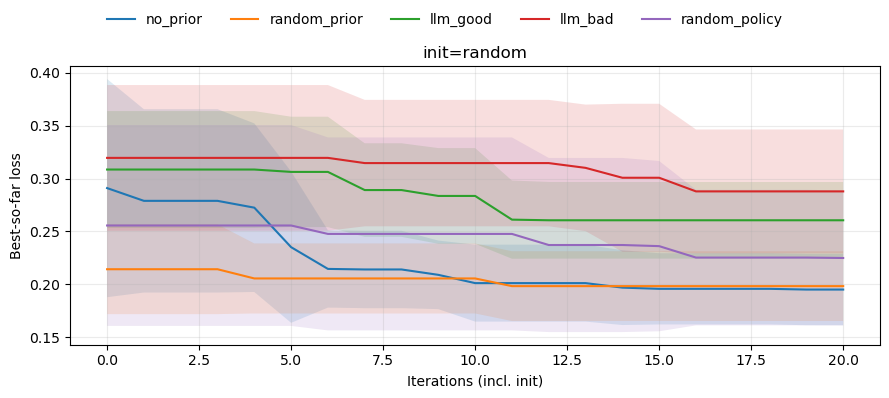

In [56]:
# Reproducible run (fixed seed)
import warnings
warnings.filterwarnings("ignore")
summary_df, figs, fig_all, paths = run_benchmark_jupyter(
    oracle_path="agnp_oracle_out/oracle.pkl",
    data_csv="AgNP_dataset.csv",
    out_dir="agnp_bench_llm_nb",
    priors=("no_prior","random_prior","llm_good","llm_bad","random_policy"),
    init_modes=("random"),
    n_reps=6, n_init=6, iters=20, cand_pool=600,
    seed=3231, randomize=True, fresh_llm=True,
    return_per_combo_plots=False, return_combined_fig=True, save_plots=True
)

In [41]:
# ===== BoTorch repeatable benchmark: STGP + {EI, qEI, UCB, PI} + Random =====
import numpy as np
import pandas as pd
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from botorch.acquisition.monte_carlo import qExpectedImprovement as qEI
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
import matplotlib.pyplot as plt
import os
from botorch.acquisition import LogExpectedImprovement


torch.set_default_dtype(torch.double)

# --- helpers: schema <-> unit cube ---
def _schema_cols(schema): 
    return [v.name for v in schema.continuous]

def _to_unit(schema, X_df):
    cols = _schema_cols(schema)
    X = X_df[cols].to_numpy(dtype=float)
    lows  = np.array([v.low  for v in schema.continuous], dtype=float)
    highs = np.array([v.high for v in schema.continuous], dtype=float)
    return (X - lows) / (highs - lows + 1e-12)

def _from_unit(schema, U):
    cols = _schema_cols(schema)
    lows  = np.array([v.low  for v in schema.continuous], dtype=float)
    highs = np.array([v.high for v in schema.continuous], dtype=float)
    X = lows + U * (highs - lows)
    return pd.DataFrame(X, columns=cols)

def _mix_seed(*vals) -> int:
    """Simple deterministic seed mixer."""
    out = 2166136261
    for v in vals:
        out ^= int(v) & 0xFFFFFFFF
        out *= 16777619
        out &= 0x7FFFFFFF
    return out

# --- acquisition factory (minimization via sign flip) ---
def _build_acqf(acq_name: str, model, y_bo: torch.Tensor):
    """
    acq_name ∈ {"EI", "qEI", "UCB", "PI"}
    model: fitted SingleTaskGP
    y_bo: targets after sign flip (maximize -loss)
    """
    name = acq_name.lower()
    if name =="logei":
        return LogExpectedImprovement(model=model, best_f=float(y_bo.max()))
    if name == "ei":
        return ExpectedImprovement(model=model, best_f=float(y_bo.max()))
    if name == "qei":
        sampler = SobolQMCNormalSampler(num_samples=512)
        return qEI(model=model, best_f=float(y_bo.max()), sampler=sampler)
    if name == "ucb":
        # tweak beta as you like; larger beta = more exploration
        return UpperConfidenceBound(model=model, beta=2.0)
    if name == "pi":
        # small jitter to encourage improvement attempts
        return ProbabilityOfImprovement(model=model, best_f=float(y_bo.max()), tau=1e-3)
    raise ValueError(f"Unknown acquisition: {acq_name}")






def sobol_seed_df(schema, n, seed=0):
    import torch, numpy as np, pandas as pd
    cols = [v.name for v in schema.continuous]
    lows  = np.array([v.low  for v in schema.continuous], float)
    highs = np.array([v.high for v in schema.continuous], float)
    d = len(cols)
    eng = torch.quasirandom.SobolEngine(d, scramble=True, seed=int(seed)&0x7FFFFFFF)
    U = eng.draw(n).numpy()
    X = lows + U*(highs-lows)
    return pd.DataFrame(X, columns=cols)


def mixed_seed(df_all, schema, n_total=10, n_worst=2, seed=0):
    import numpy as np
    rng = np.random.default_rng(seed)
    # base Sobol
    Xs = sobol_seed_df(schema, n_total - n_worst, seed=seed)
    # add a couple worst from your dataset (diverse)
    worst = df_all.sort_values("loss", ascending=False).head(max(2*n_worst, n_worst))
    feats = [v.name for v in schema.continuous]
    Xw = worst.sample(n=n_worst, random_state=int(rng.integers(0, 2**31)))[feats].reset_index(drop=True)
    return pd.concat([Xs, Xw], ignore_index=True)

# --- one BO run (q can be 1 for analytic EI/UCB/PI; q>1 only for MC qEI) ---
def run_botorch_closed_loop_one(
    oracle, schema, X0: pd.DataFrame,
    iters: int = 20, seed: int = 0,
    acq: str = "EI", q: int = 1,
    num_restarts: int = 8, raw_samples: int = 128,
):
    torch.manual_seed(int(seed) & 0x7FFFFFFF)
    cols = _schema_cols(schema)
    d = len(cols)

    # training tensors (unit cube); NEGATE y so we maximize -loss
    U = torch.tensor(_to_unit(schema, X0), dtype=torch.double)                 # (n0, d)
    y = torch.tensor(oracle.predict(X0), dtype=torch.double).reshape(-1, 1)    # (n0, 1)
    y_bo = -y.clone()

    best_curve = [float(y.min())]
    hist = [{**{c: float(X0.iloc[i][c]) for c in cols}, "loss": float(y[i,0]), "where": "seed"}
            for i in range(len(X0))]

    bounds = torch.stack([torch.zeros(d, dtype=torch.double),
                          torch.ones(d,  dtype=torch.double)])

    for t in range(iters):
        # fit STGP (stable: normalized inputs, standardized output)
        model = SingleTaskGP(
            train_X=U, train_Y=y_bo,
            input_transform=Normalize(d=d),
            outcome_transform=Standardize(m=1),
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        acqf = _build_acqf(acq, model, y_bo)

        # choose optimizer & q
        _q = q if acq.lower() == "qei" else 1
        cand, _ = optimize_acqf(
            acq_function=acqf,
            bounds=bounds,
            q=_q,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
            options={"batch_limit": 5, "maxiter": 200},
        )

        # take first point (even if q>1)
        u_next = cand.detach()[0].cpu().numpy()          # (d,)
        x_next = _from_unit(schema, u_next[None, :])
        y_next = oracle.predict(x_next).reshape(-1, 1)

        # append
        U    = torch.vstack([U, torch.tensor(u_next).unsqueeze(0).double()])
        y    = torch.vstack([y, torch.tensor(y_next).double()])
        y_bo = -y
        best_curve.append(float(y.min()))
        hist.append({**{c: float(x_next.iloc[0][c]) for c in cols},
                     "loss": float(y_next[0,0]), "where": "bo"})

    return np.array(best_curve, dtype=float), pd.DataFrame(hist)

# --- random policy (same X0, same iters) ---
def run_random_closed_loop_one(oracle, schema, X0: pd.DataFrame, iters: int = 20, seed: int = 0):
    rng = np.random.default_rng(int(seed) & 0x7FFFFFFF)
    cols = _schema_cols(schema); d = len(cols)
    lows  = np.array([v.low  for v in schema.continuous], dtype=float)
    highs = np.array([v.high for v in schema.continuous], dtype=float)

    y = oracle.predict(X0).reshape(-1,1)
    best_curve = [float(y.min())]
    hist = [{**{c: float(X0.iloc[i][c]) for c in cols}, "loss": float(y[i,0]), "where": "seed"}
            for i in range(len(X0))]

    for _ in range(iters):
        x = lows + rng.random(d) * (highs - lows)
        x_df = pd.DataFrame([x], columns=cols)
        y_next = oracle.predict(x_df).reshape(-1,1)
        y = np.vstack([y, y_next])
        best_curve.append(float(y.min()))
        hist.append({**{c: float(x_df.iloc[0][c]) for c in cols}, "loss": float(y_next[0,0]), "where": "random"})

    return np.array(best_curve, dtype=float), pd.DataFrame(hist)

# --- run multiple reps and aggregate ---
def run_benchmark_reps(
    oracle, schema, X0: pd.DataFrame,
    iters: int = 20, reps: int = 10, base_seed: int = 0,
    acq: str = "EI", q: int = 1,
    num_restarts: int = 8, raw_samples: int = 128,
    include_random: bool = True,
):
    curves = {}
    hists  = {}

    # BO policy
    bo_runs = []
    bo_hist_all = []
    for r in range(reps):
        seed_r = _mix_seed(base_seed, r, 1337)
        curve, hist = run_botorch_closed_loop_one(
            oracle, schema, X0, iters=iters, seed=seed_r,
            acq=acq, q=q, num_restarts=num_restarts, raw_samples=raw_samples
        )
        bo_runs.append(curve)
        bo_hist_all.append(hist.assign(rep=r))
    curves[f"BO({acq})"] = np.vstack(bo_runs)
    hists[f"BO({acq})"]  = pd.concat(bo_hist_all, ignore_index=True)

    # Random baseline
    if include_random:
        rnd_runs = []
        rnd_hist_all = []
        for r in range(reps):
            seed_r = _mix_seed(base_seed, r, 9001)
            curve, hist = run_random_closed_loop_one(oracle, schema, X0, iters=iters, seed=seed_r)
            rnd_runs.append(curve)
            rnd_hist_all.append(hist.assign(rep=r))
        curves["Random"] = np.vstack(rnd_runs)
        hists["Random"]  = pd.concat(rnd_hist_all, ignore_index=True)

    return curves, hists

# --- visualization: mean + confidence bands ---
def plot_mean_ci(curve_mat: np.ndarray, label: str, ax=None, ci: float = 0.95):
    """
    curve_mat: shape (reps, T), best-so-far curves
    """
    import numpy as np, matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()
    m = curve_mat.mean(axis=0)
    s = curve_mat.std(axis=0, ddof=1)
    n = curve_mat.shape[0]
    z = 1.96 if abs(ci - 0.95) < 1e-6 else 1.96  # keep simple; tweak if you want t-dist
    half = z * s / max(1, np.sqrt(n))
    xs = np.arange(m.size)
    ax.plot(xs, m, label=label, linewidth=2)
    ax.fill_between(xs, m - half, m + half, alpha=0.2)

def visualize_benchmark(curves: dict, title: str = "BoTorch vs Random", save_path: str | None = None):
    """
    curves: {"name": np.ndarray shape (reps, T), ...}
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    ax = plt.gca()
    for name, mat in curves.items():
        plot_mean_ci(mat, label=name, ax=ax)
    ax.set_xlabel("Iterations (incl. seeds as step 0)")
    ax.set_ylabel("Best-so-far loss")
    ax.set_title(title)
    ax.grid(alpha=0.3); ax.legend(); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches="tight")




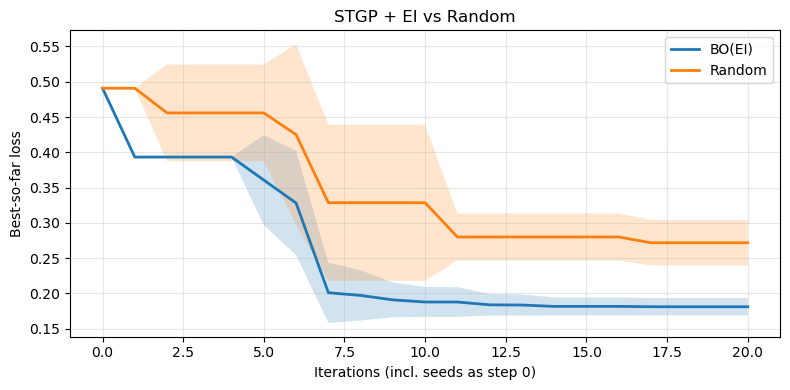

In [52]:
# Build schema/oracle and initial set as you already do
schema, df_all = derive_schema("AgNP_dataset.csv")
oracle = load_oracle("agnp_oracle_out/oracle.pkl")
X0 = mixed_seed(df_all, schema, n_total=4, n_worst=2, seed=3241)


# Run 8 repetitions of BO(EI) and Random, 20 BO iters
curves, hists = run_benchmark_reps(
    oracle=oracle,
    schema=schema,
    X0=X0,
    iters=20,
    reps=4,
    base_seed=453423,
    acq="EI",   # try: "qEI", "UCB", "PI", logeei
    q=1,        # for "qEI" you can set q>1 (batch), e.g., q=3
    num_restarts=8,
    raw_samples=128,
    include_random=True,
)

# Plot mean + 95% CI
os.makedirs("bt_bench_viz", exist_ok=True)
visualize_benchmark(curves, title="STGP + EI vs Random", save_path="bt_bench_viz/compare.png")

# # If you want, inspect raw histories:
# bo_hist  = hists["BO(EI)"]      # per-eval rows with 'rep' column
# rnd_hist = hists["Random"]


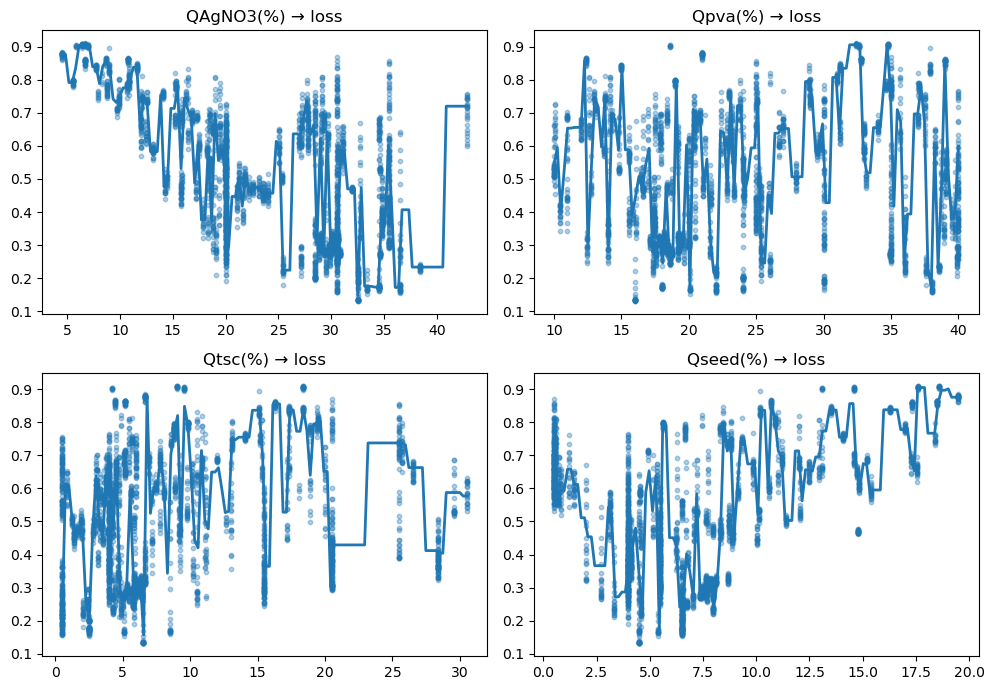

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("AgNP_dataset.csv").dropna()
cols = ["QAgNO3(%)","Qpva(%)","Qtsc(%)","Qseed(%)","Qtot(uL/min)","loss"]

def smooth_xy(x, y, k=11):
    # KNN smoother for a quick monotonicity glance
    x = x.reshape(-1,1)
    knn = KNeighborsRegressor(n_neighbors=min(k, len(x)))
    knn.fit(x, y)
    xs = np.linspace(x.min(), x.max(), 120).reshape(-1,1)
    ys = knn.predict(xs)
    return xs.ravel(), ys

fig, axes = plt.subplots(2,2, figsize=(10,7))
pairs = [("QAgNO3(%)","loss"),("Qpva(%)","loss"),("Qtsc(%)","loss"),("Qseed(%)","loss"),("Qtot(uL/min)","loss")]
for ax,(v, y) in zip(axes.ravel(), pairs):
    x = df[v].values; t = df[y].values
    xs, ys = smooth_xy(x, t, k=15)
    ax.scatter(x, t, s=10, alpha=0.35)
    ax.plot(xs, ys, lw=2)
    ax.set_title(f"{v} → {y}")
plt.tight_layout()

In [ ]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy


In [76]:
# ================== AX STANDALONE CLOSED LOOP (robust for Ax 1.1.0) ==================
import re


def _ax_read_init_requirement(ax_client):
    """
    Best-effort: read how many observed trials Ax wants before switching to GP.
    Returns an int or None if unknown.
    """
    try:
        gs = ax_client.generation_strategy
        # Common attrs across versions:
        step0 = getattr(gs, "_steps", [None])[0]
        if step0 is None:
            return None
        # min_trials_observed is what usually gates the switch to GP
        mto = getattr(step0, "min_trials_observed", None)
        if isinstance(mto, int) and mto >= 0:
            return mto
        # fallback: some builds gate on num_trials instead
        nt = getattr(step0, "num_trials", None)
        if isinstance(nt, int) and nt >= 0:
            return nt
    except Exception:
        pass
    return None

def _ax_try_set_init_requirement(ax_client, k: int) -> bool:
    """
    Try to set init requirement to k using any API we can:
    1) configure_generation_strategy (public on some builds)
    2) private attrs on generation_strategy._steps[0]
    Returns True if we *believe* we set it, False otherwise.
    """
    # 1) Public knob (if available)
    if hasattr(ax_client, "configure_generation_strategy"):
        try:
            ax_client.configure_generation_strategy(
                initialization_budget=int(k),
                initialize_with_center=False,
                allow_exceeding_initialization_budget=True,
                use_existing_trials_for_initialization=True,
            )
            return True
        except Exception:
            pass

    # 2) Private-attr patch (brittle; guarded)
    try:
        gs = ax_client.generation_strategy
        step0 = getattr(gs, "_steps", [None])[0]
        if step0 is None:
            return False
        # lower both if present
        if hasattr(step0, "min_trials_observed"):
            setattr(step0, "min_trials_observed", int(k))
        if hasattr(step0, "num_trials"):
            setattr(step0, "num_trials", int(k))
        return True
    except Exception:
        return False


def _ax_parameters_from_schema(schema: lsp.Schema):
    return [{
        "name": v.name,
        "type": "range",
        "bounds": [float(v.low), float(v.high)],
        "value_type": "float",
    } for v in schema.continuous]

def _ax_create_experiment(ax_client, name, parameters, objective_name="loss", minimize=True):
    # Try modern/simple path
    try:
        return ax_client.create_experiment(
            name=name,
            parameters=parameters,
            objective_name=objective_name,
            minimize=minimize,
        )

    except TypeError:
        pass
    # Try "objectives" mapping path
    try:
        from ax.service.utils.instantiation import ObjectiveProperties
        objectives = {objective_name: ObjectiveProperties(minimize=minimize)}
        return ax_client.create_experiment(name=name, parameters=parameters, objectives=objectives)
    except Exception:
        pass
    # Try "objective" dict path
    try:
        objective = {"name": objective_name, "minimize": minimize}
        return ax_client.create_experiment(name=name, parameters=parameters, objective=objective)
    except Exception as e:
        raise TypeError("Ax create_experiment signature not supported by this wrapper.") from e


# --- add this helper once ---
def _sample_sobol_df(schema: lsp.Schema, n: int, seed: int) -> pd.DataFrame:
    import torch, numpy as np, pandas as pd
    cols = [v.name for v in schema.continuous]
    lows  = np.array([v.low  for v in schema.continuous], dtype=float)
    highs = np.array([v.high for v in schema.continuous], dtype=float)
    d = len(cols)
    eng = torch.quasirandom.SobolEngine(d, scramble=True, seed=int(seed) & 0x7FFFFFFF)
    u = eng.draw(n).numpy()                       # [0,1]^d
    X = lows + u * (highs - lows)                 # scale to bounds
    return pd.DataFrame(X, columns=cols)


def _ax_attach_and_get_index(ax_client, parameters: dict) -> int:
    """
    Version-proof way to get the trial index from attach_trial:
    compare trial key sets before/after attach.
    """
    before = set(ax_client.experiment.trials.keys())
    ax_client.attach_trial(parameters=parameters)  # ignore return type completely
    after = set(ax_client.experiment.trials.keys())
    new_keys = list(after - before)
    if not new_keys:
        # Fallback: last resort — parse largest key or parse from repr
        # (Shouldn't happen, but keep a parachute.)
        if after:
            return int(sorted(after)[-1])
        # try parsing repr (very unlikely needed)
        m = re.search(r"Trial\((\d+)\)", repr(ax_client.experiment.trials))
        if m:
            return int(m.group(1))
        raise RuntimeError("Failed to identify newly attached trial index.")
    return int(new_keys[0])

def _ax_get_next(ax_client):
    """
    Normalize get_next_trial return across versions to (params_dict, trial_index).
    """
    out = ax_client.get_next_trial()

    # Common: tuple
    if isinstance(out, tuple) and len(out) == 2:
        a, b = out
        if isinstance(a, int) and isinstance(b, dict):
            return b, int(a)
        if isinstance(b, int) and isinstance(a, dict):
            return a, int(b)
        # Trial-like + dict
        if hasattr(a, "arm") and isinstance(b, dict):
            idx_attr = getattr(a, "index", None)
            idx_val = idx_attr() if callable(idx_attr) and a.__class__.__name__.endswith("Trial") else idx_attr
            return b, int(idx_val)
        if hasattr(b, "arm") and isinstance(a, dict):
            idx_attr = getattr(b, "index", None)
            idx_val = idx_attr() if callable(idx_attr) and b.__class__.__name__.endswith("Trial") else idx_attr
            return a, int(idx_val)

    # Trial-like object only
    if hasattr(out, "arm") and hasattr(out.arm, "parameters"):
        params = out.arm.parameters
        idx_attr = getattr(out, "index", None)
        idx_val = idx_attr() if callable(idx_attr) and out.__class__.__name__.endswith("Trial") else idx_attr
        # If idx_val is still weird, grab the latest key
        if not isinstance(idx_val, (int,)) and hasattr(ax_client, "experiment"):
            idx_val = sorted(ax_client.experiment.trials.keys())[-1]
        return params, int(idx_val)

    # Rare dict form
    if isinstance(out, dict):
        params = out.get("parameters") or out.get("arm", {}).get("parameters")
        trial_idx = out.get("trial_index") or out.get("index")
        if params is not None and trial_idx is not None:
            if callable(trial_idx):  # don't call generic 'index' methods
                # fall back to experiment key-diff approach:
                # generate again, record new key; but safer to raise here
                raise TypeError("Ambiguous trial index callable encountered.")
            return params, int(trial_idx)

    raise TypeError(f"Unsupported get_next_trial return type: {type(out)}")
def run_ax_closed_loop_service(
    oracle,
    schema: lsp.Schema,
    X0: pd.DataFrame,
    iters: int = 20,
    seed: int = 0,
    experiment_name: str = "agnp_ax_bo",
    configure_quality: bool = False,      # <- safer to keep False
    target_init_trials: int | None = None # <- desired observed count before GP
):
    import numpy as np, pandas as pd
    from ax.service.ax_client import AxClient

    ax_client = AxClient(random_seed=int(seed) & 0x7FFFFFFF)

    _ax_create_experiment(
        ax_client,
        name=experiment_name,
        parameters=_ax_parameters_from_schema(schema),
        objective_name="loss",
        minimize=True,
    )

    # (optional) avoid "quality" GS that may alter warm-start rules
    if configure_quality and hasattr(ax_client, "configure_generation_strategy"):
        try:
            ax_client.configure_generation_strategy(method="quality")
        except Exception:
            pass

    # Detect Ax's init requirement; default to 10 if unknown
    default_req = _ax_read_init_requirement(ax_client)
    req = int(default_req if default_req is not None else 10)

    # If caller asked for a target, we can't *lower* Ax's internal rule via service API,
    # but we can ensure we *meet* at least max(req, target). That avoids extra Sobol later.
    if target_init_trials is not None:
        req = max(req, int(target_init_trials))

    feat_cols = [v.name for v in schema.continuous]

    # 1) Attach your X0
    y0 = oracle.predict(X0)
    best_curve = [float(np.min(y0))]
    hist_rows = []
    for i, row in X0.iterrows():
        params_i = {c: float(row[c]) for c in feat_cols}
        t_idx = _ax_attach_and_get_index(ax_client, params_i)
        ax_client.complete_trial(trial_index=t_idx, raw_data=float(y0[i]))
        hist_rows.append({**params_i, "loss": float(y0[i]), "where": "seed"})

    # 2) If we are still below the observed-init requirement, pad with our own Sobol
    deficit = req - len(X0)
    if deficit > 0:
        X_pad = _sample_sobol_df(schema, n=deficit, seed=seed + 4321)
        y_pad = oracle.predict(X_pad)
        for i, row in X_pad.iterrows():
            params_i = {c: float(row[c]) for c in feat_cols}
            t_idx = _ax_attach_and_get_index(ax_client, params_i)
            ax_client.complete_trial(trial_index=t_idx, raw_data=float(y_pad[i]))
            hist_rows.append({**params_i, "loss": float(y_pad[i]), "where": "warmup"})
        best_curve[0:1] = [min(np.min(y0), np.min(y_pad))]  # keep first best value consistent
        print(f"[Ax] Padded {deficit} Sobol points to satisfy init requirement ({req}).")

    # 3) BO iterations (now Ax should switch to GP immediately; no extra Sobol)
    for _ in range(iters):
        params, t_idx = _ax_get_next(ax_client)
        x_df = pd.DataFrame([{c: float(params[c]) for c in feat_cols}])
        y = oracle.predict(x_df)
        ax_client.complete_trial(trial_index=t_idx, raw_data=float(y[0]))
        best_curve.append(min(best_curve[-1], float(y[0])))
        hist_rows.append({**{c: float(params[c]) for c in feat_cols}, "loss": float(y[0]), "where": "bo"})

    hist_df = pd.DataFrame(hist_rows, columns=feat_cols + ["loss", "where"])
    return np.array(best_curve, dtype=float), hist_df, ax_client

# ================== /AX STANDALONE CLOSED LOOP ==================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def visualize_ax_results(best_curve_ax: np.ndarray,
                         hist_ax: pd.DataFrame,
                         save_dir: str | None = None):
    """
    best_curve_ax: 1D np.array of best-so-far loss (len = iters + 1)
    hist_ax: DataFrame with columns [features..., 'loss', 'where'] where 'where'∈{'seed','bo'}
    save_dir: optional directory path to save PNGs
    """
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # --- 1) Best-so-far loss curve ---
    fig1 = plt.figure(figsize=(7,4))
    xs = np.arange(len(best_curve_ax))
    plt.plot(xs, best_curve_ax, linewidth=2)
    plt.xlabel("Iterations (incl. seed as step 0)")
    plt.ylabel("Best-so-far loss")
    plt.title("Ax BO: Best-so-far loss")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_dir:
        fig1.savefig(os.path.join(save_dir, "ax_best_curve.png"), dpi=160, bbox_inches="tight")

    # --- 2) Evaluations over time (seed vs BO) ---
    # Build an iteration index for the history (seed first, then BO steps)
    hist = hist_ax.copy().reset_index(drop=True)
    hist["iter"] = np.arange(len(hist))
    fig2 = plt.figure(figsize=(7,4))
    # plot seeds
    if (hist["where"] == "seed").any():
        sub = hist[hist["where"] == "seed"]
        plt.scatter(sub["iter"].to_numpy(), sub["loss"].to_numpy(), label="seed", s=28)
    # plot BO
    if (hist["where"] == "bo").any():
        sub = hist[hist["where"] == "bo"]
        plt.scatter(sub["iter"].to_numpy(), sub["loss"].to_numpy(), label="bo", s=28)
    plt.xlabel("Evaluation index")
    plt.ylabel("Observed loss")
    plt.title("Ax BO: Observations (seed vs BO)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_dir:
        fig2.savefig(os.path.join(save_dir, "ax_observations.png"), dpi=160, bbox_inches="tight")

    # --- 3) (Optional) 2D scatter for any two features vs loss ---
    # Pick the first two feature columns if present:
    feature_cols = [c for c in hist.columns if c not in ("loss","where","iter")]
    if len(feature_cols) >= 2:
        f1, f2 = feature_cols[:2]
        fig3 = plt.figure(figsize=(6,5))
        plt.scatter(hist[f1].to_numpy(), hist[f2].to_numpy(), s=24)
        plt.xlabel(f1); plt.ylabel(f2)
        plt.title("Evaluated points in feature space")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        if save_dir:
            fig3.savefig(os.path.join(save_dir, "ax_feature_scatter.png"), dpi=160, bbox_inches="tight")

    # Return the figures in case you want to display or further tweak
    return fig1, fig2

In [77]:
schema, df_all = derive_schema("AgNP_dataset.csv")
oracle = load_oracle("agnp_oracle_out/oracle.pkl")

rng = np.random.default_rng(489)
X0 = pick_initial(df_all, n_init=1, mode="bad", rng=rng)

# Example: I want 4 init trials in total, then GP (if the build allows).
best_curve_ax, hist_ax, ax_client = run_ax_closed_loop_service(
    oracle=oracle,
    schema=schema,
    X0=pick_initial(df_all, n_init=4, mode="bad", rng=np.random.default_rng(489)),
    iters=20,
    seed=489,
    target_init_trials=0,
)

[WARNING 09-19 15:21:37] ax.service.ax_client: Random seed set to 489. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 09-19 15:21:37] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 09-19 15:21:37] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 10 trials, BoTorch for subsequent trials]). Iterations after 10 will take longer to generate due to model-fitting.
[INFO 09-19 15:21:37] ax.service.ax_client: Completed trial 0 with data: {'loss': (0.90709, None)}.
[INFO 09-19 15:21:37] ax.service.ax_client

[Ax] Padded 1 Sobol points to satisfy init requirement (5).


[INFO 09-19 15:21:37] ax.service.ax_client: Generated new trial 7 with parameters {'QAgNO3(%)': 4.958813, 'Qpva(%)': 23.226145, 'Qtsc(%)': 9.550566, 'Qseed(%)': 16.996992, 'Qtot(uL/min)': 877.754151} using model Sobol.
[INFO 09-19 15:21:37] ax.service.ax_client: Completed trial 7 with data: {'loss': (0.891372, None)}.
[INFO 09-19 15:21:37] ax.service.ax_client: Generated new trial 8 with parameters {'QAgNO3(%)': 25.257922, 'Qpva(%)': 28.40685, 'Qtsc(%)': 15.686953, 'Qseed(%)': 5.832725, 'Qtot(uL/min)': 464.054552} using model Sobol.
[INFO 09-19 15:21:37] ax.service.ax_client: Completed trial 8 with data: {'loss': (0.419884, None)}.
[INFO 09-19 15:21:37] ax.service.ax_client: Generated new trial 9 with parameters {'QAgNO3(%)': 29.696107, 'Qpva(%)': 18.791835, 'Qtsc(%)': 27.98219, 'Qseed(%)': 8.067164, 'Qtot(uL/min)': 537.983478} using model Sobol.
[INFO 09-19 15:21:38] ax.service.ax_client: Completed trial 9 with data: {'loss': (0.513283, None)}.
[INFO 09-19 15:21:38] ax.service.ax_clie

(<Figure size 700x400 with 1 Axes>, <Figure size 700x400 with 1 Axes>)

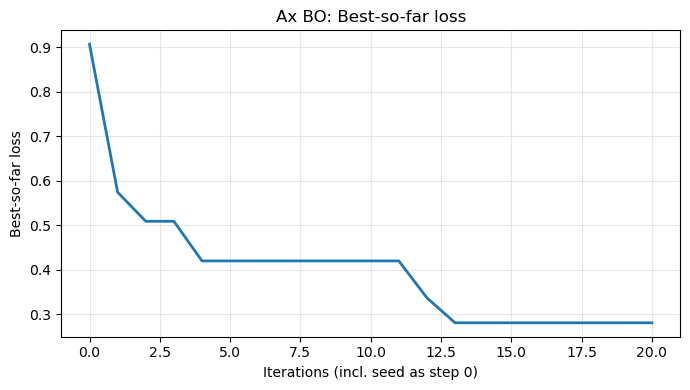

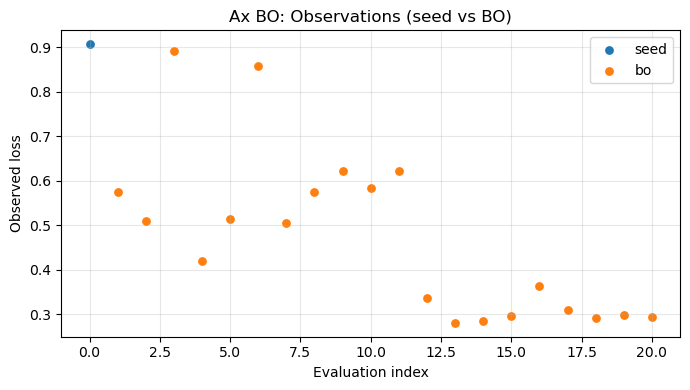

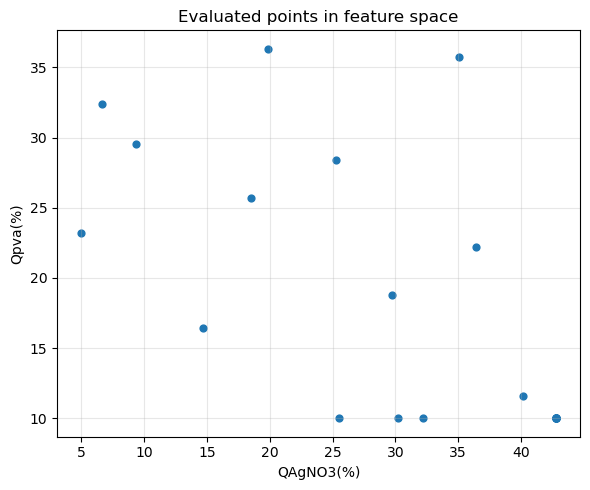

In [53]:
visualize_ax_results(best_curve_ax, hist_ax, save_dir="ax_viz")
